# Fundamentals of Neural Networks

Neural networks are a method for automatic decision-making and classification, more commonly known as weak AI. The idea developed out of synaptic connections in the brain, which output signals based on the magnitude of the incoming signals. The stronger the incoming signals, the greater the chance the neuron will activate.

In neural networks, neurons are represented by nodes, which are grouped into layers. Simple neural networks are split into three parts:

 - The **input layer**, which accepts inputs from the "outside world" - for instance, an image of a digit. 
 - The **hidden layer**, which can really be thought of as a processing layer, where computations happen.
 - The **output layer**, which returns processed information.
 
![Image courtesy the OpenCV project](http://docs.opencv.org/_images/mlp.png)

In this image, courtesy the OpenCV project, there are three input nodes, five hidden layer nodes, and two output nodes. Each node in a successive layer receives values from all of the nodes in the layer before it. Let's create this network now, as a demonstration.

In [21]:
from nnet_core import *
from transfer_funcs import linear_transfer, linear_transfer_deriv
from matplotlib.pylab import cm
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

# This will start with randomized weights and biases
weights, biases = nnet_setup([3, 5, 2], transferp=linear_transfer, transfer_derivp=linear_transfer_deriv)

A synapse in the brain can be emulated as a device with a _threshold_ and an _output_. If the inputs to the synapse are greater than the threshold, then the output is triggered. However, unlike the synapses in the brain, which must either output a 1 or 0, neural networks allow for dyanmic input and dyanmic output. To do this, nodes have two values associated with them: a weight $w$ and a bias $b$.

In order for a node to transmit a positive value, its input has to exceed its bias. This gives us the formula $x*w-b$ for a single connection. We can then write all incoming connections to a single node as follows:

Let $w_{ij}$ be the weight from node $i$ to the node $j$ between two layers, and let $b_j$ be the bias of the node $j$ in the second layer. (Note that biases are specific to the _node_, not the _connection_.) Then, the total information that goes to a single node from the previous layer is: $$\sum_i x_i * w_{ij} - b_j$$

**Neural networks as matrix multiplication**

You might notice something in the previous notation: $x_i$ and $b_j$ form column vectors, and $w_{ij}$ can form a matrix. This does hold true; consequently, we can write the computation between layers as such:

$$\left(\begin{matrix}w_{11} & \cdots & w_{1i} \\ \vdots & & \vdots \\ w_{j1} & \cdots & w_{ij} \end{matrix}\right) \left(\begin{matrix}x_1 \\ \vdots \\ x_i \end{matrix}\right) - \left(\begin{matrix}b_1 \\ \vdots \\ b_i \end{matrix}\right)$$

This makes it very easy to compute, and that is how the following function is implemented:

In [22]:
nnet_prop(weights, biases, np.rot90([[1, 1, 1]]))

array([[ 3.86145339],
       [-7.33460602]])

**Giving it something to learn**

As a demonstration, let's say we wanted to teach it to output higher on the first node if the first two numbers are higher than the third, and output higher on the second node if they aren't.

First, we need to generate some data!

In [27]:
from dataset_mgmt import *
import random as rand

training_data_count = 200

training_data = []
test_data = []
for i in range(0, training_data_count * 2):
    inp = [rand.randint(1, 10), rand.randint(1, 10), rand.randint(1, 10)]
    if(inp[2] == sorted(inp)[::-1][2]): training_data.append(([inp], 1))
    else: training_data.append(([inp], 0))
test_data = training_data[training_data_count:]
training_data = split_to_batch(training_data[:training_data_count], 10)

Why did I use 0 and 1 instead of column vectors? Part of that is a limitation of the way I wrote this library, as I wrote it with digit recognition in mind. They don't have to be, however, the utility functions I have do a handy job of turning those into target vectors:

In [24]:
print(create_tgt_vec(0, length=2), "\n")
print(create_tgt_vec(1, length=2))

[[ 0.]
 [ 1.]] 

[[ 1.]
 [ 0.]]


**Stochastic gradient descent and backpropagation**

Now it's time to see how the network actually learns something. First, it's helpful to see what it does. The code below makes a copy of the neural network we created earlier, then trains it 50 times against the training data we created.

_Note:_ Some networks will train better than others. If you get an uninteresting graph, go up to the top and create a new random network to start with.

In [28]:
# Make a copy for playing with
wts, bias = weights, biases
print("Starting accuracy: " + str(100 * nnet_evaluate_single(wts, bias, test_data)[2]) + "%")

iteration = []
evaluation = []

for i in range(0, 20):
    iteration.append(i+1)
    evaluation.append(nnet_evaluate_single(wts, bias, test_data)[2] * 100)
    wts, bias = nnet_SGD(training_data, wts, bias, 0.0010, outp_length=2)
    
print("Ending accuracy: " + str(100 * nnet_evaluate_single(wts, bias, test_data)[2]) + "%")

Starting accuracy: 32.0%
Ending accuracy: 92.0%


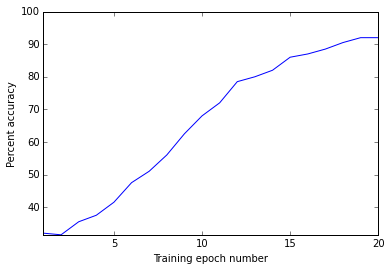

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(iteration, evaluation)
plt.ylim([min(evaluation), 100]); plt.xlim([1, max(iteration)])
plt.xlabel("Training epoch number")
plt.ylabel("Percent accuracy");

To understand what's happening, recall that the gradient of a vector always points in the direction of greatest decrease. Neural networks (ab)use this property to minimize the error of the outputs of the network. This is, in truth, the only fundamental principle at work here. We can adjust the parameters of the network to move in the direction that minimizes error. But how fast do we move? 

To answer that, the network uses a rate of movement, heretofore called the _learning rate_, represented by $\eta$. Let's call the error a _cost function_ with respect to an input vector $\vec{x}$. Then, for each $w_{ij}$, we can compute the derivative of the cost: $$\frac{dC(\vec{x})}{dw_{ij}}$$

This represents how quickly the error changes with respect to the weight. All in all, we're setting up a differential equation. $$w_{ij}' = w_{ij} - \eta \frac{dC(\vec{x})}{dw_{ij}}$$

Then, we can do the same thing for biases. What's the end result? A movement like this:

![](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)

(Courtesy datumbox)

However, notice how this network seems to reach a maximum effectiveness? Also notice how the gradients have different minima?

This is one of the problems with neural networks. There may be an absolute minimum of the network, but you won't be able to get there with stochastic gradient descent. Instead, we need a different tools to get us to higher accuracy. There are a number of these, which are better saved for a different overview.